In [20]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# --- Modify the Dataset to fit the CSV file ---class BCN20000Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, is_train=True):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.is_train = is_train
        
        if is_train:
            # We use the 'diagnosis' column for diagnosis instead of the column number.
           # We ensure that the data does not contain empty values and convert it to text.
            self.labels = sorted(self.df['diagnosis'].dropna().unique().astype(str))
            self.label_map = {label: i for i, label in enumerate(self.labels)}
            print(f"Found {len(self.labels)} classes: {self.label_map}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'bcn_filename']
        img_path = os.path.join(self.img_dir, img_name)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            # If an image is missing, we can revert to a black image or edit it.
            image = Image.new('RGB', (224, 224))

        if self.transform:
            image = self.transform(image)

        if self.is_train:
            # We read the diagnosis from the 'diagnosis' column
            label = str(self.df.loc[idx, 'diagnosis'])
            label_idx = self.label_map[label]
            return image, label_idx
        else:
            return image

# --- Equipment ---
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# paths
train_path = "/kaggle/input/datasets/pasutchien/bcn20000/BCN_20k_train/bcn_20k_train"
test_path = "/kaggle/input/datasets/pasutchien/bcn20000/BCN_20k_test/bcn_20k_test"

train_csv = "/kaggle/input/datasets/pasutchien/bcn20000/bcn_20k_train.csv"
test_csv = "/kaggle/input/datasets/pasutchien/bcn20000/bcn_20k_test.csv"

train_dataset = BCN20000Dataset(train_csv, train_path, transform=transform, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# --- The model (as is, with minor improvements) ---class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        #We used ResNet18 as the Feature Extractor
        self.cnn = models.resnet18(weights='IMAGENET1K_V1') 
        self.cnn.fc = nn.Identity() 
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        if x.ndim == 4: # add new dimension if it not exist 
            x = x.unsqueeze(1)
        batch_size, seq_len, C, H, W = x.size()
        c_in = x.view(batch_size*seq_len, C, H, W)
        features = self.cnn(c_in)
        features = features.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(features)
        out = self.fc(lstm_out[:, -1, :])
        return out

# --- training ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(train_dataset.labels)
model = CNN_LSTM(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Found 8 classes: {np.str_('AK'): 0, np.str_('BCC'): 1, np.str_('BKL'): 2, np.str_('DF'): 3, np.str_('MEL'): 4, np.str_('NV'): 5, np.str_('SCC'): 6, np.str_('VASC'): 7}


In [23]:
train_losses = []
train_accuracies = []

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 2. We calculate the average for each Epoch and add it to the list
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1/10 - Loss: 1.1076, Accuracy: 61.15%
Epoch 2/10 - Loss: 0.7658, Accuracy: 73.42%
Epoch 3/10 - Loss: 0.5100, Accuracy: 82.44%
Epoch 4/10 - Loss: 0.3123, Accuracy: 89.62%
Epoch 5/10 - Loss: 0.1879, Accuracy: 93.78%
Epoch 6/10 - Loss: 0.1487, Accuracy: 95.01%
Epoch 7/10 - Loss: 0.1192, Accuracy: 95.98%
Epoch 8/10 - Loss: 0.0885, Accuracy: 96.90%
Epoch 9/10 - Loss: 0.0955, Accuracy: 96.80%
Epoch 10/10 - Loss: 0.0825, Accuracy: 97.22%


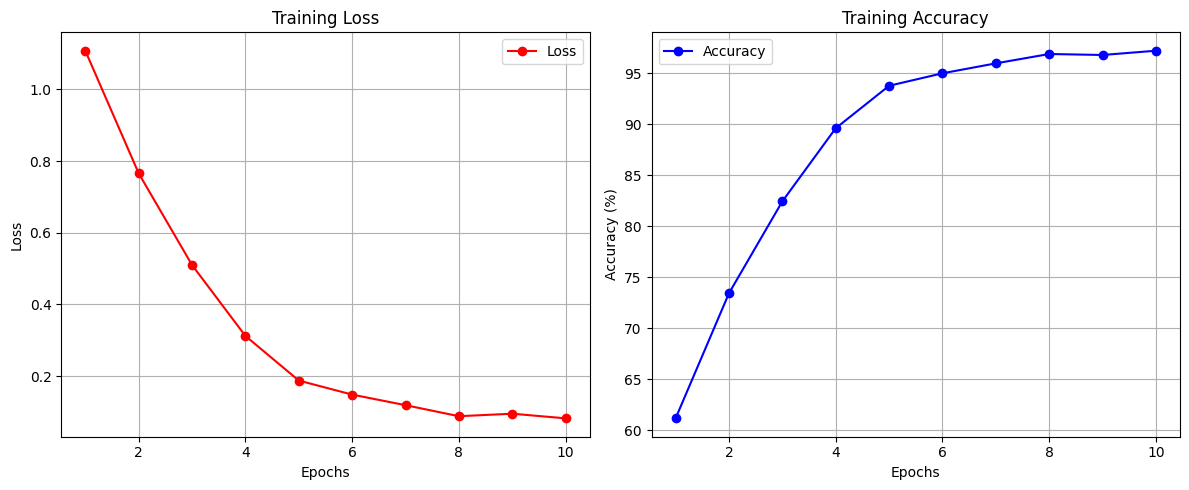

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', color='red', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#  Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='blue', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png') # save image
plt.show()

/tmp/ipykernel_55/2386877680.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, palette='viridis')
/tmp/ipykernel_55/2386877680.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=site_counts.values, y=site_counts.index, palette='magma')


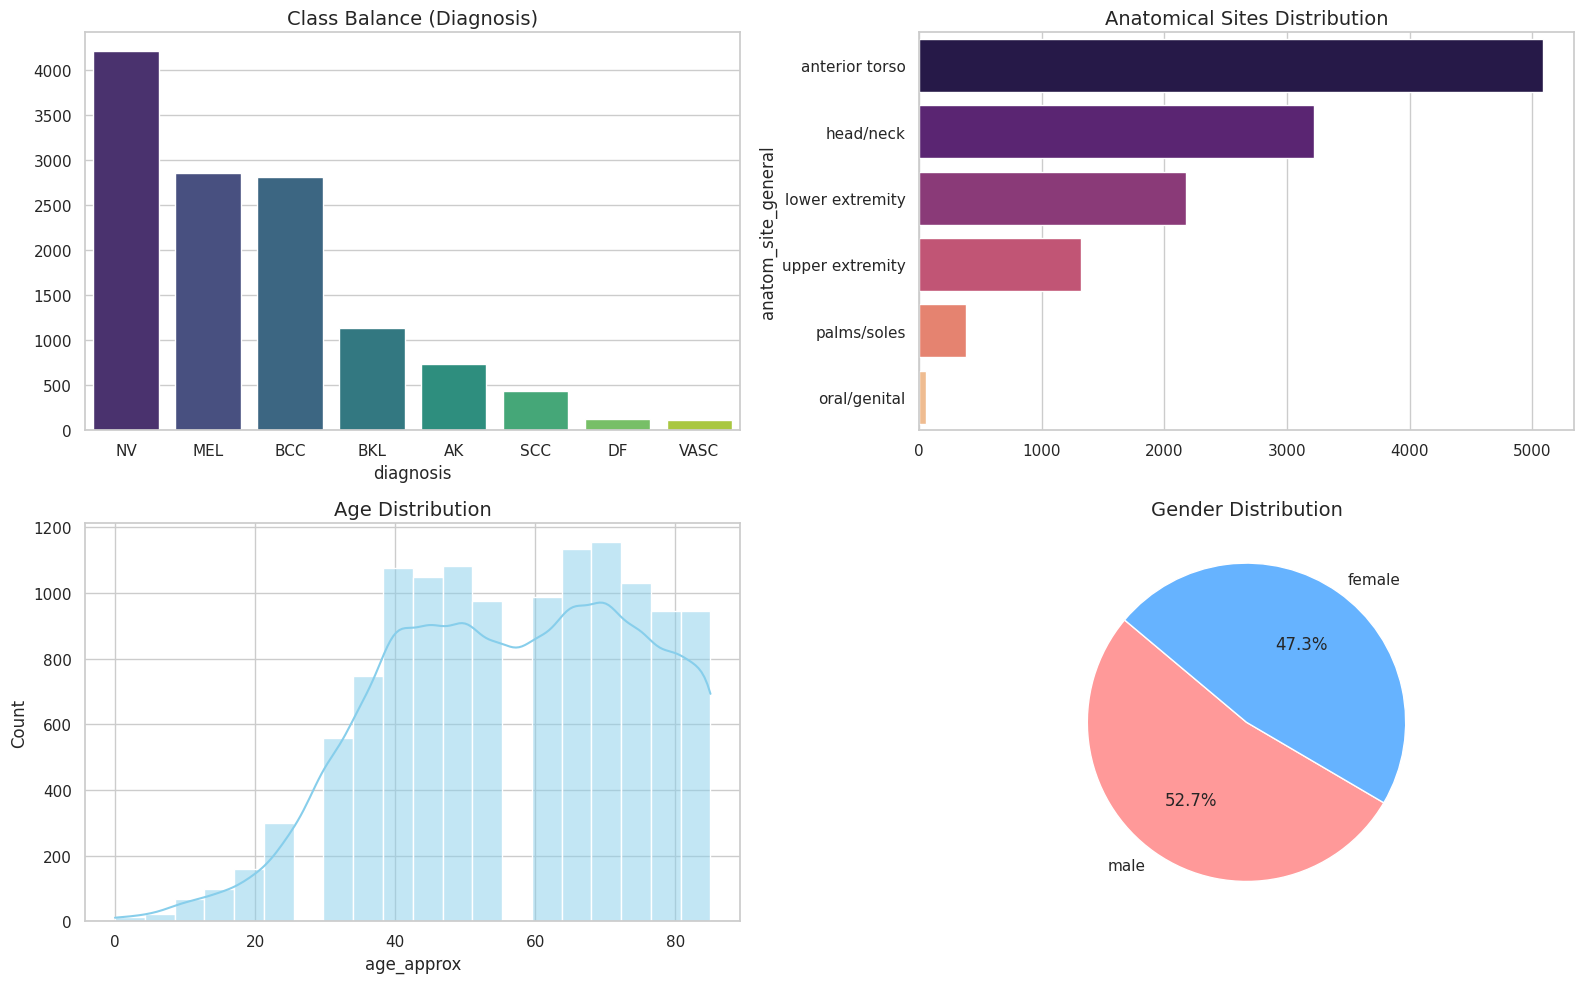

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# data loading 
df = pd.read_csv(train_csv)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 10))

# 1.  (Diagnosis)
plt.subplot(2, 2, 1)
diagnosis_counts = df['diagnosis'].value_counts()
sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, palette='viridis')
plt.title('Class Balance (Diagnosis)', fontsize=14)

# 2. (Anatomical Sites)
plt.subplot(2, 2, 2)
site_counts = df['anatom_site_general'].value_counts()
sns.barplot(x=site_counts.values, y=site_counts.index, palette='magma')
plt.title('Anatomical Sites Distribution', fontsize=14)

# 3. Ages
plt.subplot(2, 2, 3)
sns.histplot(df['age_approx'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Age Distribution', fontsize=14)

# 4.  (Male vs Female)
plt.subplot(2, 2, 4)
sex_counts = df['sex'].value_counts()
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Gender Distribution', fontsize=14)

plt.tight_layout()
plt.savefig('data_distribution.png')
plt.show()

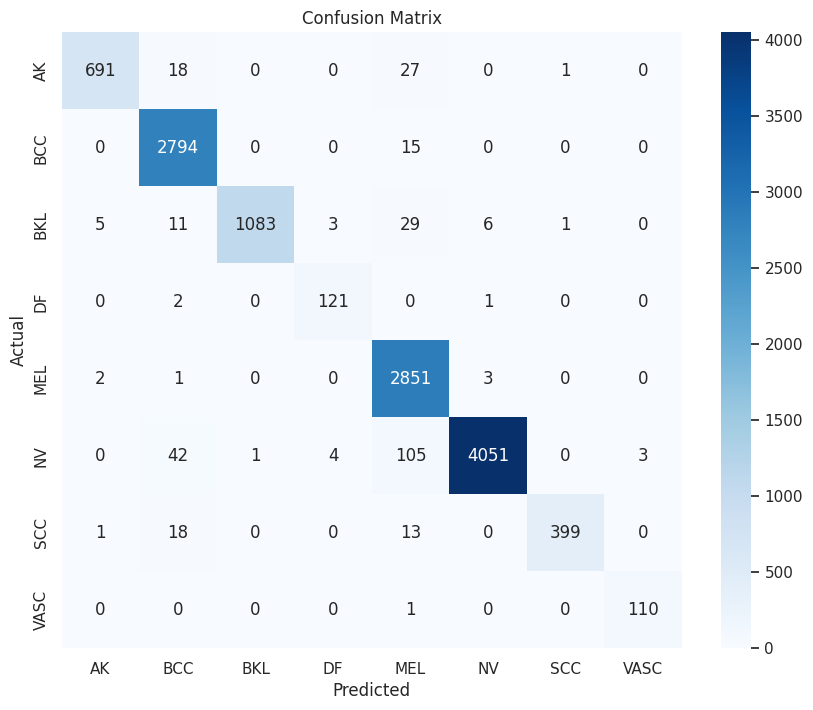

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

plot_confusion_matrix(model, train_loader, device, train_dataset.labels)

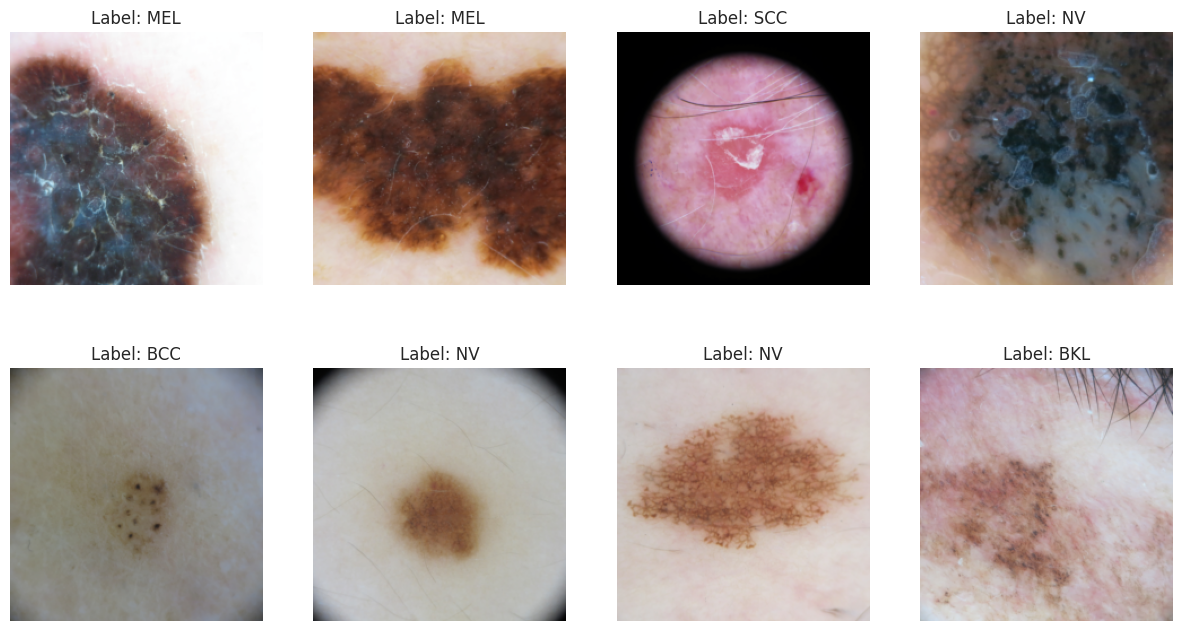

In [27]:
def show_samples(dataset, num_samples=8):
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        img, label_idx = dataset[i]
        # Restore the image from Tensor to its normal form
        img = img.permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406] # Un-normalize
        
        plt.subplot(2, 4, i+1)
        plt.imshow(img.clip(0, 1))
        plt.title(f"Label: {dataset.labels[label_idx]}")
        plt.axis('off')
    plt.savefig('samples.png')
    plt.show()

show_samples(train_dataset)

In [28]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Params: {total_params:,}")

Total Trainable Params: 11,967,048


In [29]:
# Save model
model_path = "bcn_model_v1.pth"

torch.save(model.state_dict(), model_path)

print(f"Model saved successfully to {model_path}!")

Model saved successfully to bcn_model_v1.pth!
